In [28]:
import becquerel as bq
from becquerel import Spectrum
from becquerel.tools import Isotope, IsotopeQuantity, NeutronIrradiation
import datetime
import numpy as np
import scipy.integrate as integrate
import math as m
import importlib
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
sys.path.insert(0,r"C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis")

In [29]:
import PF
import naa_isotope_analyzer as naa
import analysis_methods as am
import ROI
importlib.reload(PF)
importlib.reload(naa)
importlib.reload(am)
importlib.reload(ROI)

<module 'ROI' from 'C:\\Users\\Daniel\\Desktop\\Radwatch\\radwatch-analysis\\ROI.py'>

In [30]:
def get_isotopes(energies):
    hl_cut = 3600 #in becq.fetch decay radiation
    br_cut =4.0
    df = naa.naa_isotope_analyzer(energies.tolist(),hl_cut,br_cut)
    
    return df

In [31]:
def f_near(a,a0):
    idx = np.abs(a-a0).argmin()
    return idx
        
def plot_peak_region(spectrum,source_energies,source_isotopes):
    roi.find_peak_energies()
    target_peaks = roi.target_peaks
    print(target_peaks)
    for i,j,isotope in zip(source_energies,target_peaks,source_isotopes):
        spec = spectrum
        counts = spec.counts_vals
        energies = spec.energies_kev
        idx = f_near(energies,i) 
        roi_low = idx - 50
        roi_high = idx + 50

        plot_counts = counts[roi_low:roi_high]
        plot_energies = energies[roi_low:roi_high]

        roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(j)
        rlow = roi_low_bins[0][0]
        rhi = roi_high_bins[0][-1]
        plot_counts = counts[rlow:rhi]
        plot_energies = energies[rlow:rhi]

        rlow = roi_low_bins[0][0]
        rhi = roi_low_bins[0][-1]
        low_counts = counts[rlow:rhi]
        low_energies = energies[rlow:rhi]

        rlow = roi_high_bins[0][0]
        rhi = roi_high_bins[0][-1]
        high_counts = counts[rlow:rhi]
        high_energies = energies[rlow:rhi]

        rlow = roi_peak_bins[0][0]
        rhi = roi_peak_bins[0][-1]
        peak_counts = counts[rlow:rhi]
        peak_energies = energies[rlow:rhi]

        fig,ax = plt.subplots()
        ax.plot(plot_energies,plot_counts)
        ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
        ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
        ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
        ax.set_yscale('log')
        plt.title(isotope)
        #plt.savefig('isotope %s.png'%isotope,dpi = 200)
        
def efficiency(roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
    eff = []
    eff_uncer = []
    for count,A,br,sigma_c,sigma_A in zip (roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
        eff.append(count/spectrum.livetime/A/br)
        eff_uncer.append(m.sqrt((sigma_c/A)**2+(count*sigma_A/A**2)**2)/br/spectrum.livetime)
    return eff, eff_uncer

In [32]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()
def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print('fit gain:', cal.gain, 'keV/channel')
    print('fit channels:', cal.fit_channels)

    plt.figure()
    plt.title('Peaks used in fit')
    cal.plot()
    plt.tight_layout()
    #plt.savefig('peaks used in fit.png',dpi = 200)

    plot_spec(cal.peakfinder.spectrum, xmode='channel')
    for x, erg in zip(cal.fit_channels, cal.fit_energies):
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-10:chan+10].max() * 1.5
        plt.plot([x, x], [1e-1, y], 'r-', alpha=0.5)
        plt.text(x, y, '{:.1f} keV'.format(erg))
    #plt.savefig('Uncal spec.png',dpi = 200)


    plot_spec(cal.peakfinder.spectrum, xmode='energy')
    for erg in cal.fit_energies:
        x = int(erg / cal.gain)
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-15:chan+15].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], 'r-', alpha=0.5)
        plt.text(erg, y, '{:.1f} keV'.format(erg))
    #plt.savefig('cal spec.png',dpi=200)

In [33]:
#use the ecal and bgspec from google drive
#implement choosing between relevant ecal and bg for diff sample groups
e_cal = np.loadtxt(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\11-19-2019-Calibration.Ent")
bgspec =  Spectrum.from_file(r"C:/Users/Daniel/Desktop/Radwatch/FishSamples2019/background.Spe")
#detector ϵ placeholder = .001

SpeFile: Reading file C:/Users/Daniel/Desktop/Radwatch/FishSamples2019/background.Spe


C:\Users\Daniel\Anaconda3\lib\site-packages\becquerel-0.2.4-py3.7.egg\becquerel\parsers\spectrum_file.py:136: SpectrumFileParsingWarning: Spectrum will be initated without an energy calibration;invalid calibration, energies not monotonically increasing.
  SpectrumFileParsingWarning)


In [34]:
#specs for testing
spec_30 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1901-30min.Spe")
spec_03 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1901-3hr.Spe")
spec_24 = Spectrum.from_file(r"C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1901-24hr.Spe")

SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1901-30min.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1901-3hr.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\FishSamples2019\ucb1901-24hr.Spe


In [6]:
specs= [spec_30,spec_03,spec_24]
cal_specs = []
bgspec = am.apply_ecal(bgspec, e_cal)
for i in range(len(specs)):
    cal_specs.append(am.apply_ecal(specs[i],e_cal))

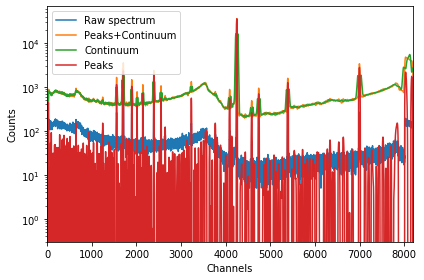

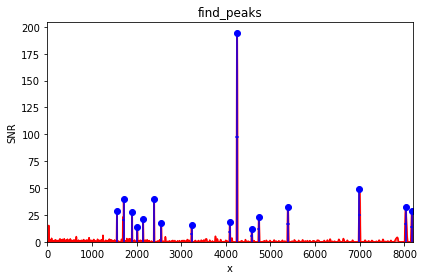

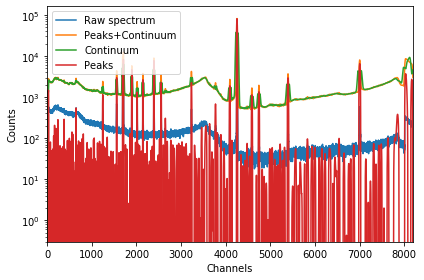

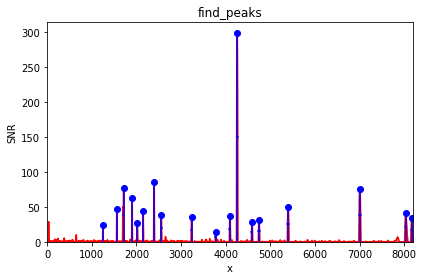

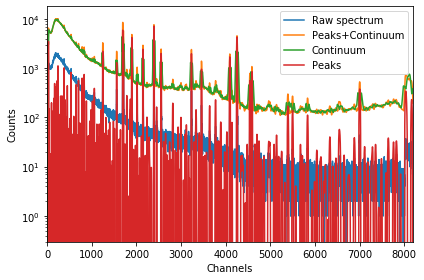

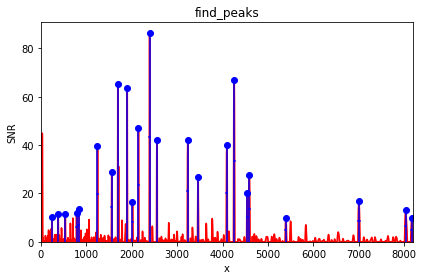

In [7]:
energies = []
for i in range(len(cal_specs)):
    energies.append(am.get_energies(cal_specs[i])) #peak finding method, bq.peakfinder


In [8]:
iso_dfs =[]
#isotope analyzer improvement
for e in energies:
    iso_dfs.append(get_isotopes(e))

Verified Isotopes, [['ZN71'], ['BR82'], ['BR82'], ['TE131'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['NA24'], ['BR82'], ['K42'], [], []]
Verified Isotopes, [['HO166'], ['ZN71'], ['HO166'], ['BR82'], ['TE131'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['TA182'], ['BR82'], ['NA24'], ['BR82'], ['K42'], [], []]
Verified Isotopes, [['TE131'], ['TE131'], ['HF179'], ['HF179'], ['LU177'], ['LU177'], ['ZN71'], ['BR82'], ['BR82'], ['TE131'], ['BR82'], ['BR82'], ['BR82'], ['BR82'], ['TE131'], ['BR82'], ['NA24'], ['K40'], ['BR82'], [], []]


In [26]:
iso_dfs

[          isotopes                                energies  \
 0             BR82  [556, 616, 695, 824, 1039, 1311, 1468]   
 1            TE131                                   [653]   
 2             ZN71                                   [508]   
 3              K42                                  [1518]   
 4  SE Unidentified                                  [1724]   
 5             NA24                                  [1362]   
 6            AC228                                   [773]   
 
                                     branching_ratios  
 0  [0.7170000000000001, 0.43700000000000006, 0.28...  
 1                                           [0.0418]  
 2                                            [0.287]  
 3                                           [0.1808]  
 4                                           [[None]]  
 5                                         [0.999936]  
 6                                           [0.0149]  ,
           isotopes                          

In [9]:
print(iso_dfs[2].energies[0])

[551, 616, 695, 774, 825, 1040, 1313, 1471]


In [10]:
vars(iso_dfs[0])

{'_is_copy': None, '_data': BlockManager
 Items: Index(['isotopes', 'energies', 'branching_ratios'], dtype='object')
 Axis 1: RangeIndex(start=0, stop=7, step=1)
 ObjectBlock: slice(0, 3, 1), 3 x 7, dtype: object, '_item_cache': {}}

In [11]:
print(iso_dfs[0].energies[0])

[556, 616, 695, 824, 1039, 1311, 1468]


In [12]:
i1 = bq.Isotope(iso_dfs[0].isotopes[0])
print(i1)

Br-82


In [35]:
print(energies)#arrays for all spectra
print(energies[0])#array for a spectra in increasing energy
print(iso_dfs[0].energies) #the energies seperated per identified spectra
print(iso_dfs[0].energies[0])#the energies for one isotope in 1 spectra
print("The isotope", iso_dfs[0].isotopes[0], "has energy peaks at",iso_dfs[0].energies[0],"and br for each energy", iso_dfs[0].branching_ratios[0])

[array([ 508,  556,  616,  653,  695,  773,  824, 1039, 1311, 1362, 1468,
       1518, 1724, 2234]), array([ 409,  508,  557,  616,  654,  695,  773,  824, 1040, 1211, 1312,
       1364, 1470, 1519, 1726, 2236]), array([  91,  135,  184,  263,  277,  410,  508,  551,  616,  654,  695,
        774,  825, 1040, 1112, 1313, 1364, 1455, 1471, 1726, 2236])]
[ 508  556  616  653  695  773  824 1039 1311 1362 1468 1518 1724 2234]
0    [556, 616, 695, 824, 1039, 1311, 1468]
1                                     [653]
2                                     [508]
3                                    [1518]
4                                    [1724]
5                                    [1362]
6                                     [773]
Name: energies, dtype: object
[556, 616, 695, 824, 1039, 1311, 1468]
The isotope BR82 has energy peaks at [556, 616, 695, 824, 1039, 1311, 1468] and br for each energy [0.7170000000000001, 0.43700000000000006, 0.284, 0.242, 0.276, 0.26899999999999996, 0.16390000000

In [14]:
a = []
a.append(iso_dfs[0].isotopes)
a

[0               BR82
 1              TE131
 2               ZN71
 3                K42
 4    SE Unidentified
 5               NA24
 6              AC228
 Name: isotopes, dtype: object]

In [23]:
print(iso_dfs[0].energies[0][0])
print(iso_dfs[0].branching_ratios[0][0])
print(range(len(iso_dfs[0].energies[0])))

556
0.7170000000000001
range(0, 7)


In [27]:
nrg_inp = np.array(iso_dfs[0].energies[0])
r,u = am.get_counts(cal_specs[0],bgspec,nrg_inp)
list1 = r/cal_specs[0].livetime
list2 =iso_dfs[0].branching_ratios[0]
products = [a * b for a, b in zip(list1, list2)]
c= np.sum(products)
brbr= iso_dfs[0].branching_ratios[0]
print(products)
print(c/np.sum(brbr))

C:\Users\Daniel\Anaconda3\lib\site-packages\becquerel-0.2.4-py3.7.egg\becquerel\core\spectrum.py:726: SpectrumWarning: Subtraction of counts-based specta, spectra have been converted to CPS
  'have been converted to CPS', SpectrumWarning)


[1.3342063240739483, 0.3109698601460885, 0.12983742329816672, 0.08742353373179895, 0.09849776149533573, 0.08695508746612325, 0.026494604623281858]
0.8683430008936092


In [ ]:
for k in range(len(cal_specs)):
    for j in iso_dfs:
        for i in range(len(j.energies:
            c,u = am.get_counts(cal_specs[k],bgspec,i)
            l1 = c/cal_specs[k].livetime
            l2 = j.branc

In [25]:
spectra_cnts = {"Spectrum 1 Counts":s1cnts,"Spectrum 2 Counts":s2cnts,"Spectrum 3 Counts":s3cnts}
spectra_cnts = pd.DataFrame(spectra_cnts)
spectra_cnts 

NameError: name 's1cnts' is not defined

In [17]:
Abr = []
ibrs = []
iAs = []
mbrs =[]
for i in iso_dfs:
    for j in range(len(i.energies)):
        for k in range(len(i.energies[j])):
            ibrs = np.sum(i.branching_ratios[j][k])
            iAs = i.energies[j][k] # want counts/livetime not energies
            mbrs = i.branching_ratios[j][k]
            
print(ibrs)
#print(iAs)

0.0192


In [18]:
iso_array = []
for i in iso_dfs:
    for j in i.isotopes:
        if j in iso_array:
           continue 
        else: 
            iso_array.append(j)

In [19]:
nrg_array = [] #keep energies with isotope? maybe this is where I find the total cps of the isotope and put it in
for i in iso_dfs:
    for j in i.energies:
        if j in nrg_array:
           continue 
        else: 
            nrg_array.append(j)

In [20]:
iso_npt = {'isotopes':iso_array}#,"energies":nrg_array}   

isotopes = pd.DataFrame(iso_npt)
isotopes

,isotopes
0,BR82
1,TE131
2,ZN71
3,K42
4,SE Unidentified
5,NA24
6,AC228
7,TA182
8,HO166
9,HF179


#keep counts associated with isotopes, not just raw energy input
#reimplementing
cnts = []
uncs = []
icnts = []
iuncs = []
spcnt = []
spunc = []
for i in range(len(cal_specs)):
    for j in range(len(iso_dfs[i].energies)):
        icnts, iuncs = am.get_counts(cal_specs[i],bgspec,iso_dfs[i].energies[j])
        spcnt.append(icnts) #how to split arrays for each isotope's energies and keep with each relevant spectra
        spunc.append(iuncs)
        c.append(spcnt)
        u.append(spunc)
        spcnt = []
        spunc = []
    

In [21]:
print(cnts)
#print(cnts[0])#counts for one iso
#find a way to order them by spectra at least

NameError: name 'cnts' is not defined

In [ ]:
#counts = []
#uncertainties =[]
#icounts = []
#iuncertainties = []
#uses PF.PF 
#for i in range(len(cal_specs)):
    icounts, iuncertainties = am.get_counts(cal_specs[i],bgspec,energies[i])
    counts.append(icounts)
    uncertainties.append(iuncertainties)

In [ ]:
print(counts)

In [ ]:
print(cal_specs[0].livetime)

In [ ]:
cps=[]
uncs =[]
for i in range(len(cal_specs)):
    cps.append(counts[i]/cal_specs[i].livetime)
    uncs.append(uncertainties[i]/cal_specs[i].livetime)

In [ ]:
print((cps))

In [ ]:
ϵ = .005
br = 1
A=[]
unc = []
for i in range(len(counts)):
    A.append(am.iso_activity(cps[i],br,ϵ))
    unc.append(am.iso_activity(uncs[i],br,ϵ))

In [ ]:
len(A)

In [ ]:
for i in range(len(A)):
    for j in range(len(A[i])):
        A[i][j] = int(A[i][j])

In [ ]:
print(A)

In [ ]:
t0 = cal_specs[0].start_time.timestamp() - (4*24*60*60) #time of irrad
print(t0)

In [ ]:
dts=[] #time of measure since time of irradiation

for i in range(len(cal_specs)):
    dts.append(am.get_dt(cal_specs[i],t0))
print(dts)

In [ ]:
iso_dfs[0]
#index through the dataframe, get info on each iso
#plug in relevant info to the eq. for each iso
#be able to select iso of interest?
#output all recognized isotopes per sample per measurement?

In [ ]:
flux = 2*10**11 #from davis trigger reactor
Tirrad = 1 *3600 #sec irradiated

#nndc scraping for verified isotope list and 
#get hl,M_A, xs, iso abundance, then list

hl_na24 = 14.9 *3600 #sec
xs_na24 = 0.531399 * (1*10**-24)
M_A = 22.989769 #g/mol
sample_wt = 1 #g
iso_abundance =1 #100% na23